<a href="https://colab.research.google.com/github/mnrazamohamed/Deep-Learning-for-Image-Recognition/blob/main/DL_Deep_Learning_for_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Image Recognition

Name: Raza Mohamed

Student ID: 24148501



This project focuses on developing a deep learning model to classify images of cats and dogs using both VGG19 and YOLOv11 architectures. The objective was to build models capable of accurately distinguishing between cat and dog images by leveraging a custom dataset and incorporating best practices in model training, augmentation, regularization, hyperparameter tuning, and evaluation.

1) **Dataset Preparation**  
   The dataset consists of labeled images of cats and dogs, organized into training and validation directories. YOLO-compatible labels were created programmatically, assigning each image a full bounding box and class ID. This structured setup allowed seamless integration with both classification and object detection pipelines.

2) **Preprocessing and Augmentation**  
   All images were resized and normalized. For VGG19, additional preprocessing steps included Gaussian blur and detail enhancement to reduce noise. Augmentation was applied using ImageDataGenerator for classification and YOLO-native augmentations for detection. These included random rotation, zoom, shifting, shearing, horizontal flipping, and mosaic augmentation—improving generalization and reducing overfitting.

3) **Model Design (VGG19)**  
   The classification model was built using VGG19 as the base, with the convolutional layers frozen to retain pretrained features. On top of this, custom dense layers were added, along with Batch Normalization, LeakyReLU activations, Dropout layers, and L2 regularization to improve training stability and control overfitting.

4) **Hyperparameter Tuning**  
   Optuna was employed to tune key hyperparameters, including learning rate, dropout rate, number of dense units, and LeakyReLU slope. The optimization goal was to maximize the validation F1 score, ensuring robust performance across unseen data.

5) **YOLOv11 Model Setup**  
   The YOLOv11 nano model was used for object detection. It was trained with custom augmentation and regularization parameters using the reformatted dataset. Metrics such as classification loss, precision, recall, and mean average precision (mAP) were monitored during training.

6) **Model Evaluation**  
   Both models were evaluated using precision, recall, F1 score, and accuracy. A confusion matrix was generated for detailed insight into misclassifications. Additionally, performance graphs including loss, accuracy, precision, and recall over epochs were plotted to visualize learning progress.

7) **Results and Model Saving**  
   The results, including training/validation metrics, were saved in a CSV file. The best-performing VGG19 model was saved in .keras format and the YOLOv11 model in .pt format for future use and deployment.

This project demonstrates a complete deep learning pipeline that combines transfer learning, object detection with YOLOv11, image augmentation, regularization, and AutoML for binary image classification and detection. It showcases the full workflow from dataset preparation and model design to training, hyperparameter tuning, and performance evaluation.


## Mount Google Drive  
The google.colab library is used to mount Google Drive to the Colab environment. This allows access to files stored in Google Drive by mounting it at /content/drive. After running the code, a prompt will appear to authorize access to Google Drive.


In [ ]:
# Mount Google Drive to access stored files
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define image path  
The variable img_path is assigned the file path to the ZIP archive containing the "Dogs vs Cats" dataset. The dataset is located in the user's Google Drive under the specified directory.


In [ ]:
img_path  = '/content/drive/MyDrive/BCU - MSc in AI/DL ASMT2/dogs-vs-cats-vvsmall.zip'


## Extract and organize dataset  
This code extracts the dogs-vs-cats-vvsmall.zip file located in Google Drive to the specified directory (/content/). The extracted files are moved up if they are in a nested folder, ensuring that the images are directly available in the designated output directory. Any existing files in the destination directory are removed before moving the new files.


In [ ]:
import zipfile
import os
import shutil

# Define output directories for the extracted files
train_images_dir = '/content/'

# Create directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)

# Extract the train_images.zip file
with zipfile.ZipFile(img_path, 'r') as zip_ref:
    zip_ref.extractall(train_images_dir)
print("Extracted train_images.zip to", train_images_dir)

# If the extracted folder contains an extra 'train_images' folder, move its content up
nested_train_folder = os.path.join(train_images_dir, "train_images")
if os.path.exists(nested_train_folder) and os.path.isdir(nested_train_folder):
    for file in os.listdir(nested_train_folder):
        src = os.path.join(nested_train_folder, file)
        dest = os.path.join(train_images_dir, file)
        # Remove the destination file if it exists
        if os.path.exists(dest):
            os.remove(dest)
        shutil.move(src, dest)
    os.rmdir(nested_train_folder)
    print("Moved files from nested 'train_images' folder to", train_images_dir)


Extracted train_images.zip to /content/


## Define dataset paths  
The paths for the training and validation datasets are defined. The train_path points to the directory containing the training images, with subdirectories for "cats" and "dogs". Similarly, the validation_path points to the validation dataset with separate directories for "cats" and "dogs". These paths will be used later to load the images for model training and validation.


In [ ]:
train_path = '/content/dogs-vs-cats-vvsmall/train'
train_cat_path = train_path + '/cats'
train_dog_path = train_path + '/dogs'

validation_path = '/content/dogs-vs-cats-vvsmall/validation'
validation_cat_path = validation_path + '/cats'
validation_dog_path = validation_path + '/dogs'

## Print the number of images in each directory  
The number of images in the training and validation directories for both cats and dogs are printed. This provides an overview of the dataset's size, showing the count of images for each class in both the training and validation sets.


In [ ]:
# print out the number of images in the directories
print('total training cat images:', len(os.listdir(train_cat_path)))
print('total training dog images:', len(os.listdir(train_dog_path)))
print('total validation cat images:', len(os.listdir(validation_cat_path)))
print('total validation dog images:', len(os.listdir(validation_dog_path)))

total training cat images: 3000
total training dog images: 3000
total validation cat images: 900
total validation dog images: 900


## Load and store images  
The images from the training and validation directories for both cats and dogs are loaded and stored in separate lists (train_cat_imgs, train_dog_imgs, validation_cat_imgs, and validation_dog_imgs). Each image is opened using the PIL library and appended to the respective list. The image files are sorted based on their filenames before being loaded to ensure a consistent order.


In [ ]:
from PIL import Image

train_cat_imgs = []
train_dog_imgs = []
validation_cat_imgs = []
validation_dog_imgs = []

for path, arr in [(train_cat_path,train_cat_imgs), (train_dog_path,train_dog_imgs), (validation_cat_path,validation_cat_imgs), (validation_dog_path,validation_dog_imgs)]:
  image_files = sorted(os.listdir(path), key=lambda x: int(x.split('.')[1]))
  for img_file in image_files:
      img_path = os.path.join(path, img_file)
      img = Image.open(img_path)
      arr.append(img)

## Visualize sample images  
This code visualizes the first 5 images from the training set for both cats and dogs. The images are displayed in a 2x5 grid using matplotlib. Each image is shown without axis labels for a cleaner presentation. The images of cats and dogs are displayed in separate rows.


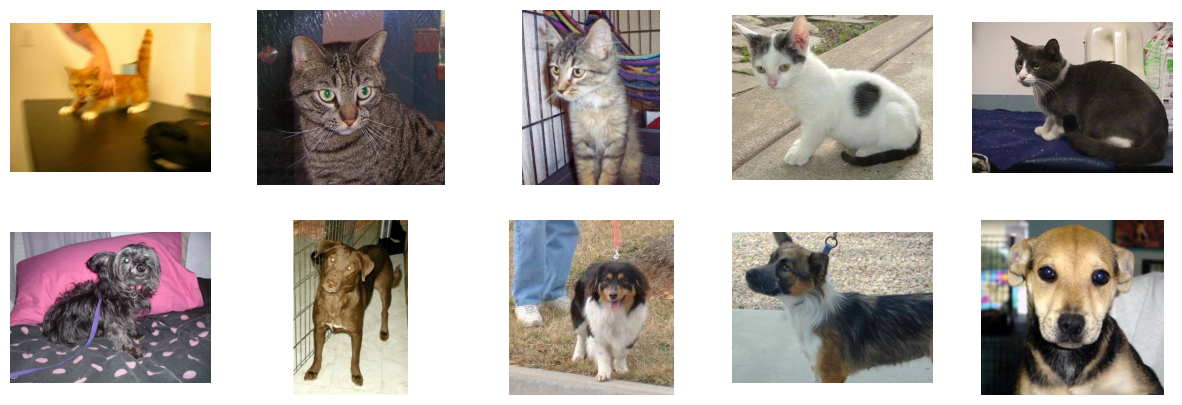

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
for row, imgs in enumerate([train_cat_imgs, train_dog_imgs]):
    for col, img in enumerate(imgs[:5]):
        plt.subplot(2, 5, row * 5 + col + 1)
        plt.imshow(img)
        plt.axis('off')

plt.show()

## Preprocess images  
The preprocess_image function is defined to preprocess each image by converting it to RGB, resizing it to a target size of (128, 128), and applying Gaussian blur for slight noise reduction. Additionally, the DETAIL filter is applied to enhance the image details. This function is applied to all images in the training and validation sets for both cats and dogs.


In [ ]:
from PIL import ImageFilter

def preprocess_image(img, target_size=(128, 128), blur_radius=0.8):
    # Ensure the image is in RGB mode
    img = img.convert("RGB")

    # Resize image to target size
    img = img.resize(target_size)

    # Apply Gaussian Blur for slight noise reduction
    img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    img = img.filter(ImageFilter.DETAIL)

    return img

# Apply the preprocessing function to all images in train_imgs
train_cat_imgs = [preprocess_image(img) for img in train_cat_imgs]
train_dog_imgs = [preprocess_image(img) for img in train_dog_imgs]
validation_cat_imgs = [preprocess_image(img) for img in validation_cat_imgs]
validation_dog_imgs = [preprocess_image(img) for img in validation_dog_imgs]


## Visualize preprocessed images  
This code visualizes the first 5 preprocessed images from the training set for both cats and dogs. The images are displayed in a 2x5 grid using matplotlib. Each image is shown without axis labels to focus on the content. The preprocessed images of cats and dogs are displayed in separate rows, showing the effect of resizing and filtering applied in the preprocessing step.


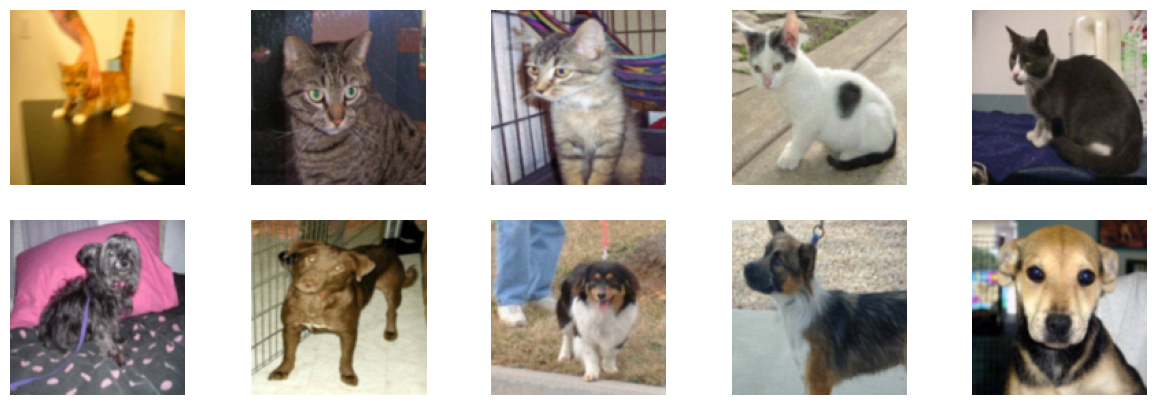

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
for row, imgs in enumerate([train_cat_imgs, train_dog_imgs]):
    for col, img in enumerate(imgs[:5]):
        plt.subplot(2, 5, row * 5 + col + 1)
        plt.imshow(img)
        plt.axis('off')

plt.show()

## Import necessary libraries  
This code imports essential libraries for building and training a deep learning model. tensorflow is used for model building, VGG16 is imported as a pre-trained model for feature extraction, and various layers such as Dense, Flatten, and Dropout are imported for constructing the neural network. The img_to_array function is used to convert images to numpy arrays, and the Adam optimizer is used for model training. Additionally, f1_score from scikit-learn is imported for evaluating the model's performance.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score

## Convert images to NumPy arrays and prepare data  
The function images_to_array converts a list of PIL images into NumPy arrays. All image lists (cats and dogs for both training and validation sets) are converted into arrays.  

The images are then combined into X_train and X_val datasets for training and validation, respectively. The labels for cats (0) and dogs (1) are created and assigned to y_train and y_val.  

Finally, the pixel values of the images are normalized by dividing by 255.0 to ensure they are within the range [0, 1], as required by the VGG16 model. The shapes of the training and validation data, as well as the labels, are printed to confirm proper formatting.


In [ ]:
# Convert PIL images to NumPy arrays
def images_to_array(image_list):
    return np.array([img_to_array(img) for img in image_list])

# Convert all image lists to arrays
train_cat_arrays = images_to_array(train_cat_imgs)
train_dog_arrays = images_to_array(train_dog_imgs)
validation_cat_arrays = images_to_array(validation_cat_imgs)
validation_dog_arrays = images_to_array(validation_dog_imgs)

# Combine cats and dogs into training and validation sets
X_train = np.concatenate([train_cat_arrays, train_dog_arrays], axis=0)
X_val = np.concatenate([validation_cat_arrays, validation_dog_arrays], axis=0)

# Create labels (0 for cats, 1 for dogs)
y_train = np.array([0] * len(train_cat_arrays) + [1] * len(train_dog_arrays))
y_val = np.array([0] * len(validation_cat_arrays) + [1] * len(validation_dog_arrays))

# Normalize the pixel values (VGG16 expects values in [0, 1])
X_train = X_train / 255.0
X_val = X_val / 255.0

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (6000, 128, 128, 3)
Validation data shape: (1800, 128, 128, 3)
Training labels shape: (6000,)
Validation labels shape: (1800,)


## Clean up memory  
Unused variables such as train_cat_imgs, train_dog_imgs, validation_cat_imgs, validation_dog_imgs, and their corresponding arrays are deleted to free up memory. The garbage collector (gc.collect()) is invoked to ensure that memory is properly released and optimized.


In [ ]:
del train_cat_imgs, train_dog_imgs, validation_cat_imgs, validation_dog_imgs
del train_cat_arrays, train_dog_arrays, validation_cat_arrays, validation_dog_arrays
del imgs
import gc
gc.collect()

14331

## Initialize dictionaries to store models and scores  
Two dictionaries, models and model_scores, are initialized. The models dictionary will be used to store the model objects, while the model_scores dictionary will keep track of the performance metrics for each model.


In [ ]:
# Initialize dictionaries to store models and scores
models = {}
model_scores = {}

## Install Optuna  
The command !pip install optuna is used to install the Optuna library, which will be used for hyperparameter optimization to improve the performance of the models.


In [ ]:
!pip install optuna

## Import libraries and define custom F1 score metric  
This code imports necessary libraries for model building and evaluation. TensorFlow is used for creating the neural network model, and VGG19 is imported as a pre-trained feature extractor. Several Keras layers (Dense, Flatten, Dropout) are included to build the model, and img_to_array is used for image preprocessing. The Adam optimizer and metrics like Precision and Recall are also imported.  

A custom F1 score metric is defined, where true positives, false positives, and false negatives are calculated, followed by the computation of precision, recall, and F1 score. This custom metric will be used to evaluate the model's performance during training and validation.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Custom F1 score metric
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Round predictions to 0 or 1
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

## Image Augmentation with ImageDataGenerator
Defines a data augmentation pipeline using Keras' ImageDataGenerator. This applies random transformations such as rotation, shifting, zooming, shearing, and flipping to training images. These augmentations help improve model generalization by introducing image diversity and reducing overfitting during training.


In [ ]:
# Requires longer runtime (Colab limit).

# # Add these imports at the top with other imports (e.g., after "from tensorflow.keras.callbacks import EarlyStopping")
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Place this right before the "def objective(trial: Trial):" line, after X_train and X_val are defined
# train_datagen = ImageDataGenerator(
#     rotation_range=20,        # Random rotations up to 20 degrees
#     width_shift_range=0.2,    # Horizontal shifts
#     height_shift_range=0.2,   # Vertical shifts
#     shear_range=0.2,          # Shear transformations
#     zoom_range=0.2,           # Random zoom
#     horizontal_flip=True,     # Random horizontal flips
#     fill_mode='nearest'       # Fill mode for transformed pixels
# )

## Import libraries and define objective function for hyperparameter tuning  
This code imports necessary libraries such as Optuna for hyperparameter optimization, TensorFlow for model building, and VGG19 as the base model for feature extraction.  

A global variable best_model, best_score, and best_history are initialized to store the best model, its F1 score, and training history.  

The objective function is defined for Optuna to tune hyperparameters such as learning rate, dropout rate, number of units in dense layers, and LeakyReLU alpha. The VGG19 model is used as a feature extractor, and custom layers are added for classification. The model is compiled with the Adam optimizer, binary cross-entropy loss, and evaluation metrics including accuracy, precision, recall, and F1 score. The model is trained with early stopping, and the best model is updated based on the highest F1 score.


In [ ]:
import optuna
from optuna.trial import Trial
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
from tensorflow.keras import regularizers

# Global storage for the best model and score
best_model = None
best_score = 0.0
best_history = None

# Updated objective function
def objective(trial: Trial):
    global best_model, best_score, best_history

    # Hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    dense_units1 = trial.suggest_int('dense_units1', 128, 512, step=64)
    dense_units2 = trial.suggest_int('dense_units2', 64, 256, step=32)
    leaky_alpha = trial.suggest_float('leaky_alpha', 0.01, 0.3, log=True)
    l2_strength = trial.suggest_float('l2_strength', 1e-5, 1e-2, log=True)

    # Load VGG19 base model
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers with L2 regularization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_units1, kernel_regularizer=regularizers.l2(l2_strength))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=leaky_alpha)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units2, kernel_regularizer=regularizers.l2(l2_strength))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=leaky_alpha)(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_strength))(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Create training generator
    # train_generator = train_datagen.flow(X_train, y_train, batch_size=32)  # Requires longer runtime (Colab limit).

    # Train the model (assuming X_train, y_train, X_val, y_val are defined)
    history = model.fit(
            X_train, y_train,
            # train_generator,  # Requires longer runtime (Colab limit).
            epochs=20,
            validation_data=(X_val, y_val),  # Validation data remains as NumPy arrays
            callbacks=[early_stopping],
            verbose=0
        )

    # Evaluate F1 score
    y_pred_prob = model.predict(X_val)
    f1_val = np.mean(f1_score(tf.constant(y_val, dtype=tf.float32), tf.constant(y_pred_prob, dtype=tf.float32)))

    # Update best model if this trial is better
    if f1_val > best_score:
        best_score = f1_val
        best_model = tf.keras.models.clone_model(model)
        best_model.set_weights(model.get_weights())
        best_history = history

    return f1_val

## Create and run the Optuna study  
An Optuna study is created with the goal of maximizing the F1 score. The study is named "VGG19_Optimizer," and the optimization process is run for 10 trials using the objective function to find the best hyperparameters for the VGG19 model.


In [ ]:

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', study_name='VGG19_Optimizer')
study.optimize(objective, n_trials=10)

[I 2025-03-28 21:19:24,600] A new study created in memory with name: VGG19_Optimizer


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


[I 2025-03-28 21:22:18,407] Trial 0 finished with value: 0.3743482232093811 and parameters: {'learning_rate': 0.000728133278777796, 'dropout_rate': 0.42744454447808033, 'dense_units1': 512, 'dense_units2': 192, 'leaky_alpha': 0.18558332406149797, 'l2_strength': 0.0004493346995341863}. Best is trial 0 with value: 0.3743482232093811.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step


[I 2025-03-28 21:29:38,271] Trial 1 finished with value: 0.3260950744152069 and parameters: {'learning_rate': 0.00019357837653582476, 'dropout_rate': 0.5733584170382584, 'dense_units1': 320, 'dense_units2': 96, 'leaky_alpha': 0.06460819768040249, 'l2_strength': 0.00019845589299180853}. Best is trial 0 with value: 0.3743482232093811.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step


[I 2025-03-28 21:36:59,852] Trial 2 finished with value: 0.33677226305007935 and parameters: {'learning_rate': 7.612962526497436e-05, 'dropout_rate': 0.289456768098703, 'dense_units1': 320, 'dense_units2': 96, 'leaky_alpha': 0.05777811312700398, 'l2_strength': 0.0015894826341961415}. Best is trial 0 with value: 0.3743482232093811.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


[I 2025-03-28 21:44:17,864] Trial 3 finished with value: 0.311663419008255 and parameters: {'learning_rate': 1.5820587695187638e-05, 'dropout_rate': 0.5837736218307127, 'dense_units1': 512, 'dense_units2': 64, 'leaky_alpha': 0.05811660597647342, 'l2_strength': 1.5582616375727352e-05}. Best is trial 0 with value: 0.3743482232093811.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step


[I 2025-03-28 21:51:28,105] Trial 4 finished with value: 0.3345656096935272 and parameters: {'learning_rate': 0.00034511307070730695, 'dropout_rate': 0.6272140720790728, 'dense_units1': 384, 'dense_units2': 160, 'leaky_alpha': 0.08889870357366486, 'l2_strength': 0.0005683961389922224}. Best is trial 0 with value: 0.3743482232093811.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step


[I 2025-03-28 21:58:47,397] Trial 5 finished with value: 0.343305379152298 and parameters: {'learning_rate': 0.00011387614659783751, 'dropout_rate': 0.3026504453924916, 'dense_units1': 192, 'dense_units2': 224, 'leaky_alpha': 0.013967630425923076, 'l2_strength': 0.0015618711063885152}. Best is trial 0 with value: 0.3743482232093811.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step


[I 2025-03-28 22:06:00,822] Trial 6 finished with value: 0.3238167464733124 and parameters: {'learning_rate': 3.782241589279062e-05, 'dropout_rate': 0.21694254149776687, 'dense_units1': 128, 'dense_units2': 96, 'leaky_alpha': 0.12020805145889454, 'l2_strength': 0.0024346785645738417}. Best is trial 0 with value: 0.3743482232093811.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step


[I 2025-03-28 22:13:15,222] Trial 7 finished with value: 0.31792348623275757 and parameters: {'learning_rate': 4.350642231961266e-05, 'dropout_rate': 0.3567961514283775, 'dense_units1': 128, 'dense_units2': 96, 'leaky_alpha': 0.0288725921681407, 'l2_strength': 0.0013973160569528964}. Best is trial 0 with value: 0.3743482232093811.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


[I 2025-03-28 22:20:37,913] Trial 8 finished with value: 0.33579331636428833 and parameters: {'learning_rate': 4.2602348798621885e-05, 'dropout_rate': 0.3828765185525096, 'dense_units1': 128, 'dense_units2': 192, 'leaky_alpha': 0.16992134871987272, 'l2_strength': 5.284173082014921e-05}. Best is trial 0 with value: 0.3743482232093811.


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step


[I 2025-03-28 22:26:24,459] Trial 9 finished with value: 0.3207547068595886 and parameters: {'learning_rate': 0.00011924429661979406, 'dropout_rate': 0.24677930554513194, 'dense_units1': 448, 'dense_units2': 160, 'leaky_alpha': 0.03207990858939952, 'l2_strength': 7.775669205765785e-05}. Best is trial 0 with value: 0.3743482232093811.


## Results  
The best validation precision from the Optuna study is printed, along with the number of finished trials. The parameters of the best trial and its corresponding validation precision are also displayed. Additionally, the best hyperparameters from the study are extracted and printed for further use.


In [ ]:
# Results
print("Best validation precision from study:", best_score)
print("Number of finished trials:", len(study.trials))
print("Best trial parameters:", study.best_trial.params)
print("Best value (Validation Precision):", study.best_value)

best_params = study.best_trial.params
print("Best parameters:", best_params)

Best validation precision from study: 0.37434822
Number of finished trials: 10
Best trial parameters: {'learning_rate': 0.000728133278777796, 'dropout_rate': 0.42744454447808033, 'dense_units1': 512, 'dense_units2': 192, 'leaky_alpha': 0.18558332406149797, 'l2_strength': 0.0004493346995341863}
Best value (Validation Precision): 0.3743482232093811
Best parameters: {'learning_rate': 0.000728133278777796, 'dropout_rate': 0.42744454447808033, 'dense_units1': 512, 'dense_units2': 192, 'leaky_alpha': 0.18558332406149797, 'l2_strength': 0.0004493346995341863}


## Display model summary  
The summary() method is called on the best_model to display a detailed overview of the model architecture. This includes the layers, the number of parameters in each layer, and the total number of parameters in the model. It provides insights into the complexity and structure of the best model found during the optimization process.


In [ ]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor (InputLayer)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,388,545 (77.78 MB)

 Trainable params: 362,753 (1.38 MB)

 Non-trainable params: 20,025,792 (76.39 MB)

## Evaluate model performance and display results  
The model's performance is evaluated on both the training and validation datasets using accuracy, precision, recall, F1 score, and the confusion matrix. Predictions for the training and validation sets are thresholded at 0.5 to determine the class (cats or dogs).  

The performance metrics are calculated using scikit-learn functions, and the results are stored in the model_scores dictionary. The confusion matrix is visualized using a heatmap for better interpretation. Additionally, a detailed classification report is printed, which includes precision, recall, and F1 score for each class (cats and dogs). The results are printed, including training and validation accuracy, precision, recall, F1 score, and the confusion matrix.


188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step
Training Accuracy: 0.8523
Validation Accuracy: 0.8283
Precision: 0.7744
Recall: 0.9267
F1 Score: 0.8437
Confusion Matrix:
 [[657 243]
 [ 66 834]]

Classification Report:
              precision    recall  f1-score   support

        Cats       0.91      0.73      0.81       900
        Dogs       0.77      0.93      0.84       900

    accuracy                           0.83      1800
   macro avg       0.84      0.83      0.83      1800
weighted avg       0.84      0.83      0.83      1800



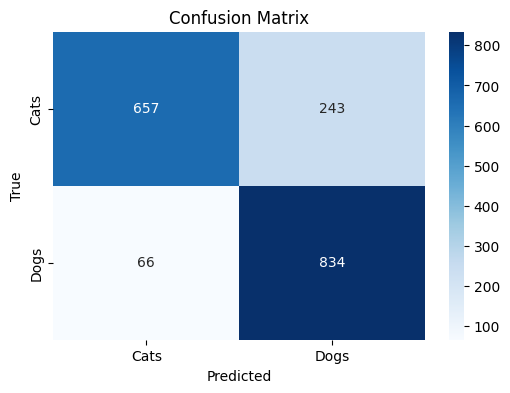

In [ ]:
y_train_pred = (best_model.predict(X_train) > 0.5).astype(int)
y_val_pred = (best_model.predict(X_val) > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
acc_diff = train_acc - val_acc
prec = precision_score(y_val, y_val_pred)
rec = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
conf_m = confusion_matrix(y_val, y_val_pred)

model_scores = {'VGG19': {
    'training_accuracy': train_acc,
    'validation_accuracy': val_acc,
    'train_val_acc_diff': acc_diff,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'confusion_matrix': conf_m
}}

models = {'VGG19': best_model}

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_m)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Cats', 'Dogs']))

# Compute and plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cats', 'Dogs'], yticklabels=['Cats', 'Dogs'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Plot model performance metrics  
Four plots are generated to visualize the model's performance during training:

1) The training and validation loss are plotted to observe how the model's error changes over epochs.

2) The training and validation accuracy are plotted to track the model's prediction accuracy over time.

3) The training and validation precision are plotted to evaluate how well the model is identifying positive classes (dogs).

4) The training and validation recall are plotted to assess how well the model is identifying all relevant instances (dogs).

Each plot includes labels for the x-axis (Epoch) and y-axis (Loss/Accuracy/Precision/Recall), with legends to differentiate between training and validation metrics.


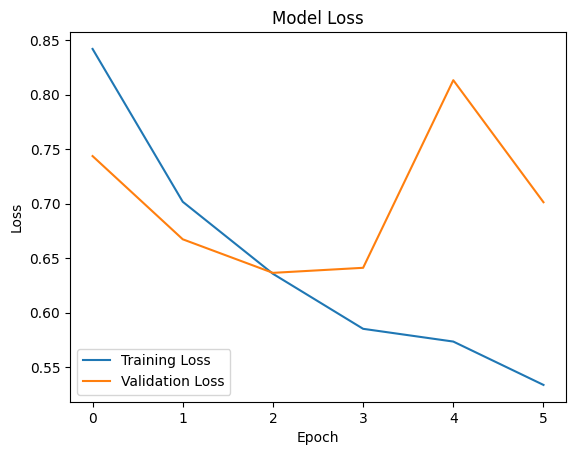

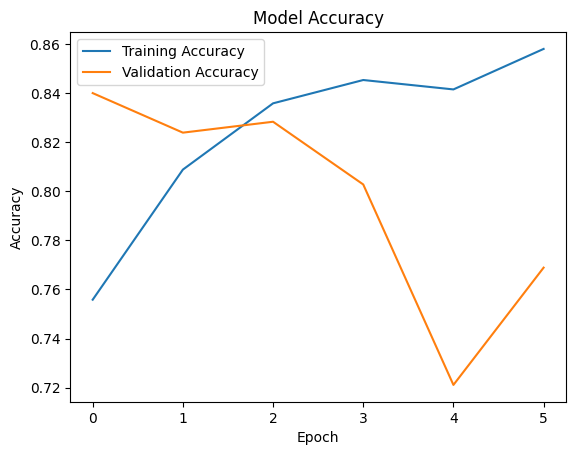

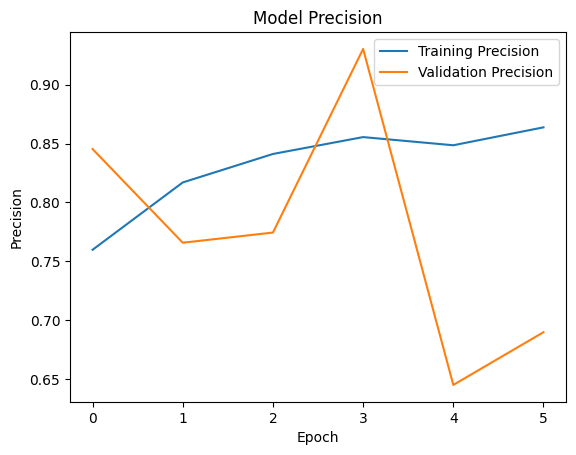

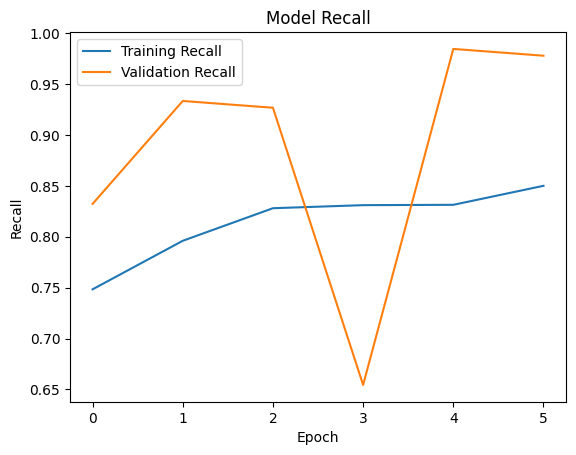

In [ ]:
import matplotlib.pyplot as plt

# 1) Plot Training & Validation Loss
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2) Plot Training & Validation Accuracy
plt.plot(best_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3) Plot Training & Validation Precision
plt.plot(best_history.history['precision'], label='Training Precision')
plt.plot(best_history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 4) Plot Training & Validation Recall
plt.plot(best_history.history['recall'], label='Training Recall')
plt.plot(best_history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()



## Display model performance scores  
The performance metrics stored in the model_scores dictionary are converted into a pandas DataFrame for better readability. This DataFrame is displayed to show the detailed evaluation results for the model, including training and validation accuracy, precision, recall, F1 score, and the confusion matrix.


In [ ]:
import pandas as pd
df_scores = pd.DataFrame.from_dict(model_scores, orient='index')
df_scores

,training_accuracy,validation_accuracy,train_val_acc_diff,precision,recall,f1_score,confusion_matrix
VGG19,0.852333,0.828333,0.024,0.774373,0.926667,0.843703,"[[657, 243], [66, 834]]"


## Save model scores and models  
The model performance scores are saved as a CSV file in the specified directory on Google Drive. If the directory does not exist, it is created. The file is saved with the name 'model_scores.csv'.  

Additionally, each model in the models dictionary is saved. If the model name is VGG19, it is saved in .h5 format, which is a common format for Keras/TensorFlow models. The file is saved in the same directory, and the path is printed after each save operation.


In [ ]:
import os
import pandas as pd
import joblib

# 2) Save the DataFrame as a CSV
save_dir = '/content/drive/MyDrive/BCU - MSc in AI/DL ASMT2/models'
os.makedirs(save_dir, exist_ok=True)  # create directory if not exists

csv_path = os.path.join(save_dir, 'model_scores.csv')
df_scores.to_csv(csv_path, index=True)
print(f"Saved model scores to: {csv_path}")

# 3) Save each model in the models dict
for model_name, model_obj in models.items():
    if model_name == 'VGG19':
        # best_model is your VGG19 (keras/tf model)
        h5_path = os.path.join(save_dir, 'VGG19_model.h5')
        model_obj.save(h5_path)
        print(f"Saved VGG19 model to: {h5_path}")

Saved model scores to: /content/drive/MyDrive/BCU - MSc in AI/DL ASMT2/models/model_scores.csv
Saved VGG19 model to: /content/drive/MyDrive/BCU - MSc in AI/DL ASMT2/models/VGG19_model.h5


## YOLO

## Install ultralytics  
The command !pip install ultralytics is used to install the Ultralytics library, which is commonly used for training and deploying models for tasks like object detection, classification, and segmentation.


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.0/950.0 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

## Prepare dataset for YOLOv11  
The directory structure for the YOLOv11 dataset is created, with separate folders for training and validation images and labels. The function prepare_yolo_data is defined to move images from the source directories to the corresponding YOLO directories (train/images, train/labels, val/images, and val/labels). For each image, a corresponding label file is generated in YOLO format, where the class ID, bounding box coordinates, and dimensions are written. The class ID is set to 0 for cats and 1 for dogs. This prepares the dataset for training a YOLOv11 model.


In [ ]:
import os
import shutil

# Define new directory structure
base_dir = '/content/yolo_dataset'
os.makedirs(f"{base_dir}/train/images", exist_ok=True)
os.makedirs(f"{base_dir}/train/labels", exist_ok=True)
os.makedirs(f"{base_dir}/val/images", exist_ok=True)
os.makedirs(f"{base_dir}/val/labels", exist_ok=True)

# Function to move images and create labels
def prepare_yolo_data(src_dir, dest_img_dir, dest_lbl_dir, class_id):
    for img_file in os.listdir(src_dir):
        if img_file.endswith(('.jpg', '.png')):  # Adjust based on your file types
            src_path = os.path.join(src_dir, img_file)
            dest_img_path = os.path.join(dest_img_dir, img_file)
            shutil.copy(src_path, dest_img_path)

            # Create label file (full image bounding box)
            label_file = os.path.splitext(img_file)[0] + '.txt'
            dest_lbl_path = os.path.join(dest_lbl_dir, label_file)
            with open(dest_lbl_path, 'w') as f:
                # YOLO format: class_id x_center y_center width height (normalized)
                f.write(f"{class_id} 0.5 0.5 1.0 1.0")

# Prepare training and validation data
prepare_yolo_data('/content/dogs-vs-cats-vvsmall/train/cats',
                  f"{base_dir}/train/images", f"{base_dir}/train/labels", 0)  # 0 = cat
prepare_yolo_data('/content/dogs-vs-cats-vvsmall/train/dogs',
                  f"{base_dir}/train/images", f"{base_dir}/train/labels", 1)  # 1 = dog
prepare_yolo_data('/content/dogs-vs-cats-vvsmall/validation/cats',
                  f"{base_dir}/val/images", f"{base_dir}/val/labels", 0)
prepare_yolo_data('/content/dogs-vs-cats-vvsmall/validation/dogs',
                  f"{base_dir}/val/images", f"{base_dir}/val/labels", 1)

print("YOLOv11 dataset prepared!")

YOLOv11 dataset prepared!


## Create YAML configuration file  
A YAML file is created to specify the dataset configuration for YOLOv11. The file includes the dataset path, paths for training and validation images, the number of classes (nc: 2 for cat and dog), and the class names. The YAML file is saved at /content/yolo_dataset/data.yaml to configure the dataset for YOLOv11 training.


In [ ]:
yaml_content = """
path: /content/yolo_dataset
train: train/images
val: val/images
nc: 2
names: ['cat', 'dog']
"""

with open('/content/yolo_dataset/data.yaml', 'w') as f:
    f.write(yaml_content)

print("YAML file created!")

YAML file created!


## Train YOLOv11 with Custom Augmentation and Regularization
Loads the YOLOv11 nano model and sets custom training hyperparameters including L2 regularization (weight decay) and advanced data augmentation options such as rotation, translation, zoom, flipping, and mosaic. The model is trained for 20 epochs on the custom cats vs dogs dataset with an image size of 128x128 and batch size of 32.


In [ ]:
from ultralytics import YOLO

# Load YOLOv11 model
model = YOLO('yolo11n.pt')  # Nano version; use 'yolo11m.pt' for medium, etc.

# Define custom hyperparameters for data augmentation and L2 regularization
hyp = {
    'weight_decay': 0.0005,  # L2 regularization (default value, explicitly set)
    'degrees': 10.0,         # Rotation range
    'translate': 0.1,        # Shift range (width and height)
    'scale': 0.5,            # Zoom range
    'shear': 0.0,            # Shear range
    'perspective': 0.0,      # Perspective transformation
    'flipud': 0.0,           # Vertical flip probability
    'fliplr': 0.5,           # Horizontal flip probability (50%)
    'mosaic': 1.0,           # Mosaic augmentation probability (enabled)
    'mixup': 0.0             # Mixup augmentation probability (disabled)
}

# Train the model with explicit hyperparameters
model.train(data='/content/yolo_dataset/data.yaml',
            epochs=20,
            imgsz=128,  # preprocessed image size
            batch=32,
            project='/content/yolo_results',
            name='yolov11_dogs_vs_cats',
            # **hyp # Requires longer runtime (Colab limit).
            )  # Pass custom hyperparameters

Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/yolo_dataset/data.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/yolo_results, name=yolov11_dogs_vs_cats2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /content/yolo_dataset/train/labels.cache... 6000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo_dataset/val/labels.cache... 1800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1800/1800 [00:00<?, ?it/s]


Plotting labels to /content/yolo_results/yolov11_dogs_vs_cats2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 2 dataloader workers
Logging results to /content/yolo_results/yolov11_dogs_vs_cats2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.496G     0.5388      1.903      1.062         47        128: 100%|██████████| 188/188 [00:47<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.61it/s]

                   all       1800       1800      0.799      0.817      0.882      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.516G     0.3307     0.8313     0.9541         48        128: 100%|██████████| 188/188 [00:34<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


                   all       1800       1800      0.869      0.856      0.902      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.525G     0.2879      0.744     0.9356         49        128: 100%|██████████| 188/188 [00:34<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.06it/s]

                   all       1800       1800      0.797      0.792      0.855       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.525G     0.2743     0.7249     0.9296         52        128: 100%|██████████| 188/188 [00:34<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.78it/s]

                   all       1800       1800      0.871      0.782      0.889      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.541G     0.2534     0.6806     0.9223         47        128: 100%|██████████| 188/188 [00:34<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.73it/s]

                   all       1800       1800      0.868      0.869      0.904      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.549G     0.2304     0.6383     0.9145         49        128: 100%|██████████| 188/188 [00:34<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.68it/s]

                   all       1800       1800      0.834      0.854      0.924        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.549G     0.2066     0.6138     0.9058         53        128: 100%|██████████| 188/188 [00:34<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.91it/s]

                   all       1800       1800      0.818      0.824       0.88      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.561G     0.2005     0.5895      0.906         52        128: 100%|██████████| 188/188 [00:34<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.78it/s]

                   all       1800       1800      0.889      0.887      0.951       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.561G     0.1894      0.567     0.9012         47        128: 100%|██████████| 188/188 [00:35<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.52it/s]

                   all       1800       1800      0.863      0.891      0.941      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.562G     0.1733     0.5502     0.8955         50        128: 100%|██████████| 188/188 [00:34<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.43it/s]


                   all       1800       1800      0.908      0.913      0.941      0.929
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.576G     0.1361     0.3949     0.8784         16        128: 100%|██████████| 188/188 [00:33<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.23it/s]

                   all       1800       1800      0.926      0.902      0.968      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.576G     0.1109     0.3246     0.8701         16        128: 100%|██████████| 188/188 [00:31<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.31it/s]

                   all       1800       1800      0.914       0.89      0.978      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.576G     0.0999     0.2997     0.8661         16        128: 100%|██████████| 188/188 [00:31<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.30it/s]

                   all       1800       1800      0.927      0.943      0.979       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.576G    0.09186     0.2759     0.8694         16        128: 100%|██████████| 188/188 [00:31<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.52it/s]

                   all       1800       1800      0.888      0.917      0.962      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.576G    0.08704      0.251     0.8654         16        128: 100%|██████████| 188/188 [00:32<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.40it/s]

                   all       1800       1800      0.931      0.924      0.976      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.576G    0.08128     0.2428     0.8613         16        128: 100%|██████████| 188/188 [00:32<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.50it/s]

                   all       1800       1800      0.952      0.882      0.975      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.576G    0.07642     0.2286     0.8607         16        128: 100%|██████████| 188/188 [00:32<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.55it/s]


                   all       1800       1800      0.891      0.914      0.956      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.576G     0.0717     0.2047     0.8643         16        128: 100%|██████████| 188/188 [00:32<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.77it/s]

                   all       1800       1800      0.946      0.918       0.98       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      0.59G    0.06602     0.1827      0.862         16        128: 100%|██████████| 188/188 [00:33<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.74it/s]

                   all       1800       1800      0.966      0.917      0.982      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      0.59G    0.06212     0.1798     0.8606         16        128: 100%|██████████| 188/188 [00:32<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]

                   all       1800       1800      0.956      0.925      0.981      0.975



20 epochs completed in 0.242 hours.
Optimizer stripped from /content/yolo_results/yolov11_dogs_vs_cats2/weights/last.pt, 5.4MB
Optimizer stripped from /content/yolo_results/yolov11_dogs_vs_cats2/weights/best.pt, 5.4MB

Validating /content/yolo_results/yolov11_dogs_vs_cats2/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.19it/s]


                   all       1800       1800      0.965      0.916      0.982      0.978
                   cat        900        900      0.975      0.906      0.981      0.976
                   dog        900        900      0.955      0.927      0.983       0.98
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/yolo_results/yolov11_dogs_vs_cats2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x789cf00d4110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## Evaluate model predictions and compute metrics  
The model's predictions on both the training and validation sets are evaluated. For each image, the predicted class is determined based on the highest confidence detection using the get_predicted_class function, while the true label is derived from the image filename using get_true_label.  

The performance metrics such as accuracy, precision, recall, F1 score, and the confusion matrix are computed using scikit-learn functions. A detailed classification report is generated, which includes precision, recall, and F1 score for each class (cats and dogs).  

The results help assess the model's performance and provide insights into its effectiveness in distinguishing between cats and dogs.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Function to extract predicted class based on highest confidence detection
def get_predicted_class(result):
    if result.boxes and len(result.boxes) > 0:  # Check if detections exist
        confidences = result.boxes.conf.cpu().numpy()  # confidence scores
        classes = result.boxes.cls.cpu().numpy()       # class IDs
        max_conf_idx = np.argmax(confidences)            # index of highest confidence
        return int(classes[max_conf_idx])                # predicted class
    else:
        # No detection found: default to class 0 (assumed to be 'cat')
        print(f"No detection found")
        return 0

# Function to derive true label from image file path
def get_true_label(file_path):
    # Assuming filenames contain "cat" or "dog"
    return 0 if 'cat' in file_path.lower() else 1

# --- Predictions on Training Set ---
train_results = model.predict(source='/content/yolo_dataset/train/images', save=False)
y_train_true = np.array([get_true_label(result.path) for result in train_results])
y_train_pred = np.array([get_predicted_class(result) for result in train_results])
del train_results

# --- Predictions on Validation Set ---
val_results = model.predict(source='/content/yolo_dataset/val/images', save=False)
y_val_true = np.array([get_true_label(result.path) for result in val_results])
y_val_pred = np.array([get_predicted_class(result) for result in val_results])
del val_results

# --- Compute Metrics ---
train_acc = accuracy_score(y_train_true, y_train_pred)
val_acc = accuracy_score(y_val_true, y_val_pred)
acc_diff = train_acc - val_acc
prec = precision_score(y_val_true, y_val_pred)
rec = recall_score(y_val_true, y_val_pred)
f1 = f1_score(y_val_true, y_val_pred)
conf_m = confusion_matrix(y_val_true, y_val_pred)
class_report = classification_report(y_val_true, y_val_pred, target_names=['Cats', 'Dogs'])


Streaming output truncated to the last 5000 lines.
image 2815/6000 /content/yolo_dataset/train/images/cat.831.jpg: 96x128 1 cat, 8.5ms
image 2816/6000 /content/yolo_dataset/train/images/cat.832.jpg: 128x128 1 cat, 13.3ms
image 2817/6000 /content/yolo_dataset/train/images/cat.833.jpg: 96x128 1 cat, 11.2ms
image 2818/6000 /content/yolo_dataset/train/images/cat.834.jpg: 128x128 1 cat, 10.1ms
image 2819/6000 /content/yolo_dataset/train/images/cat.835.jpg: 96x128 1 cat, 9.7ms
image 2820/6000 /content/yolo_dataset/train/images/cat.836.jpg: 128x128 1 cat, 10.4ms
image 2821/6000 /content/yolo_dataset/train/images/cat.837.jpg: 128x128 1 cat, 11.0ms
image 2822/6000 /content/yolo_dataset/train/images/cat.838.jpg: 128x128 1 cat, 9.3ms
image 2823/6000 /content/yolo_dataset/train/images/cat.839.jpg: 128x128 1 cat, 8.9ms
image 2824/6000 /content/yolo_dataset/train/images/cat.84.jpg: 96x128 1 cat, 9.2ms
image 2825/6000 /content/yolo_dataset/train/images/cat.840.jpg: 128x128 1 cat, 15.2ms
image 2826/60

## Store and display results  
The model's performance metrics are stored in the model_scores dictionary under the key 'YOLOv11'. This includes training and validation accuracy, precision, recall, F1 score, and the confusion matrix.

The model is also stored in the models dictionary under the key 'YOLOv11'.

The performance metrics are printed, including training accuracy, validation accuracy, precision, recall, F1 score, and the confusion matrix. Additionally, a detailed classification report is displayed.

The confusion matrix is visualized using a heatmap to better understand the model's performance in distinguishing between cats and dogs.


Training Accuracy: 0.9617
Validation Accuracy: 0.9522
Precision: 0.9339
Recall: 0.9733
F1 Score: 0.9532
Confusion Matrix:
 [[838  62]
 [ 24 876]]

Classification Report:
               precision    recall  f1-score   support

        Cats       0.97      0.93      0.95       900
        Dogs       0.93      0.97      0.95       900

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



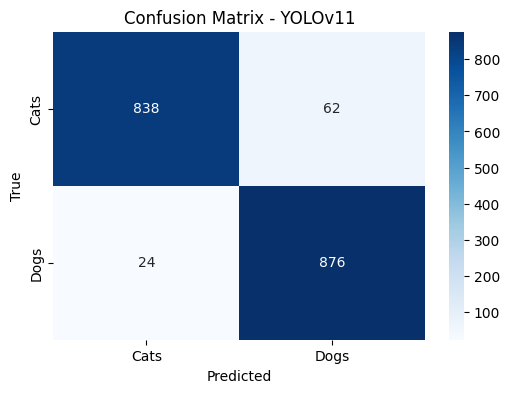

In [ ]:

# --- Store Results ---
model_scores['YOLOv11'] = {
    'training_accuracy': train_acc,
    'validation_accuracy': val_acc,
    'train_val_acc_diff': acc_diff,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'confusion_matrix': conf_m
}

models = {}  # Dictionary for storing models
models['YOLOv11'] = model

# --- Print Metrics ---
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_m)
print("\nClassification Report:\n", class_report)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6, 4))
sns.heatmap(conf_m, annot=True, fmt='d', cmap='Blues', xticklabels=['Cats', 'Dogs'], yticklabels=['Cats', 'Dogs'])
plt.title('Confusion Matrix - YOLOv11')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Plot YOLOv11 training and evaluation metrics  
The YOLOv11 training results, stored in a CSV file, are loaded into a pandas DataFrame. The training and validation metrics are then visualized in four plots:

1) **Training and Validation Loss**: The classification loss (cls_loss) is plotted for both training and validation sets to observe how the model's error decreases over epochs.

2) **Validation mAP@0.5**: The mean Average Precision (mAP) at IoU threshold 0.5 is plotted as a proxy for model accuracy.

3) **Validation Precision**: The precision metric is plotted to evaluate how well the model identifies positive classes (dogs).

4) **Validation Recall**: The recall metric is plotted to assess how well the model detects all relevant instances (dogs).

Each plot includes labels for the x-axis (Epoch) and y-axis (Loss/Precision/Recall), with a legend and


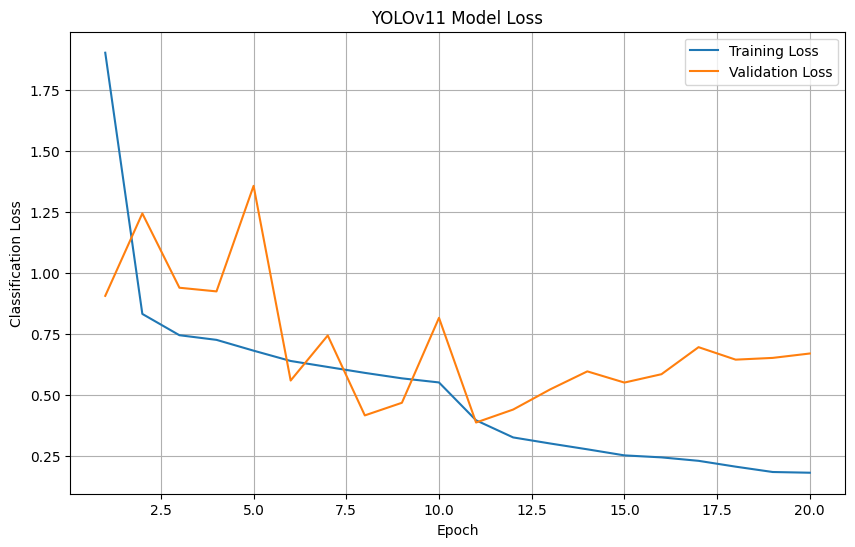

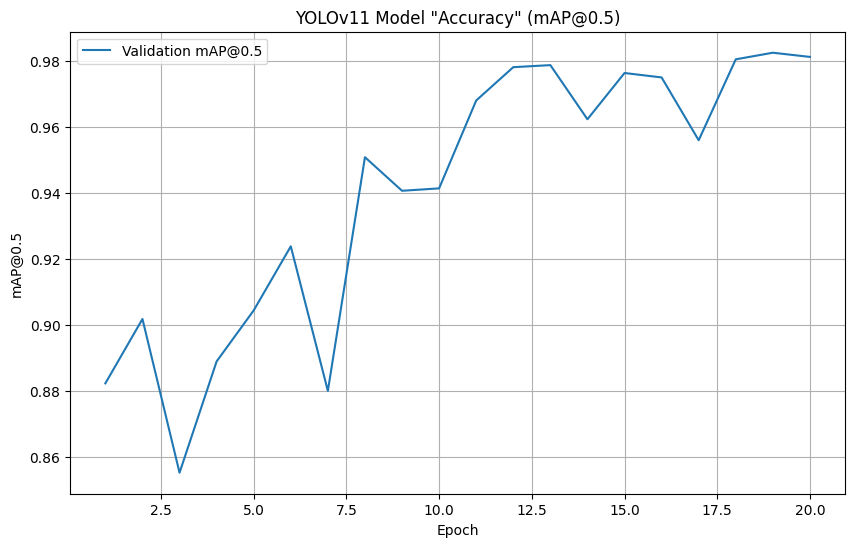

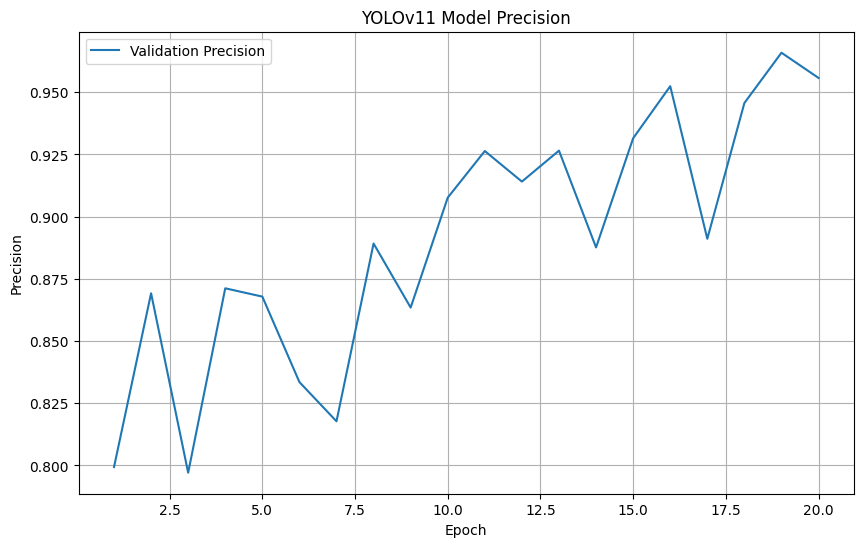

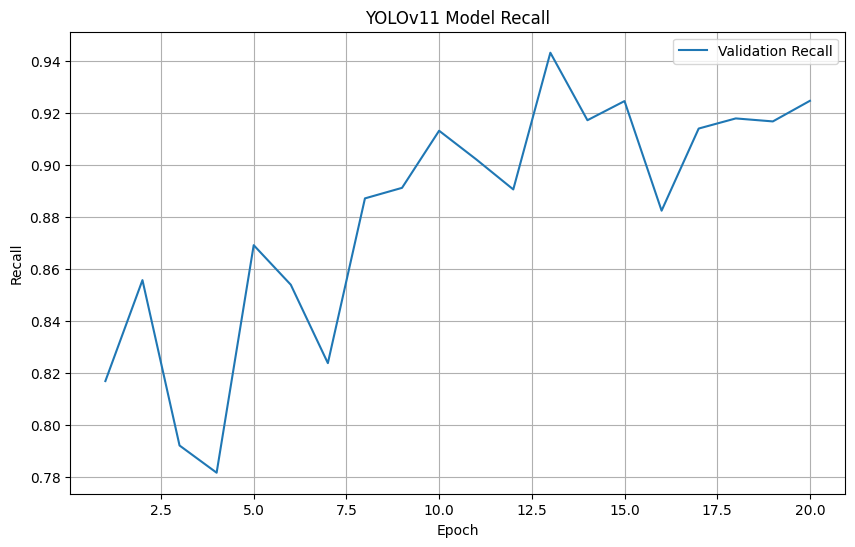

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Path to the YOLOv11 training results CSV
results_path = '/content/yolo_results/yolov11_dogs_vs_cats2/results.csv'

# Load the results
results_df = pd.read_csv(results_path)

# Strip whitespace from column names (common issue with YOLO CSV)
results_df.columns = results_df.columns.str.strip()

# 1) Plot Training & Validation Loss (using cls_loss as the primary classification loss)
plt.figure(figsize=(10, 6))
plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Training Loss')
plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Validation Loss')
plt.title('YOLOv11 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2) Plot Training & Validation "Accuracy" (using mAP@0.5 as a proxy)
plt.figure(figsize=(10, 6))
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='Validation mAP@0.5')  # No direct train mAP
plt.title('YOLOv11 Model "Accuracy" (mAP@0.5)')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.legend()
plt.grid(True)
plt.show()

# 3) Plot Validation Precision
plt.figure(figsize=(10, 6))
plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Validation Precision')
plt.title('YOLOv11 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# 4) Plot Validation Recall
plt.figure(figsize=(10, 6))
plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Validation Recall')
plt.title('YOLOv11 Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

## Display model performance scores  
The performance metrics stored in the model_scores dictionary are converted into a pandas DataFrame for better readability. This DataFrame is displayed to show the detailed evaluation results for the model, including training and validation accuracy, precision, recall, F1 score, and the confusion matrix.


In [ ]:
import pandas as pd
df_scores = pd.DataFrame.from_dict(model_scores, orient='index')
df_scores

,training_accuracy,validation_accuracy,train_val_acc_diff,precision,recall,f1_score,confusion_matrix
VGG19,0.852333,0.828333,0.024000,0.774373,0.926667,0.843703,"[[657, 243], [66, 834]]"
YOLOv11,0.961667,0.952222,0.009444,0.933902,0.973333,0.953210,"[[838, 62], [24, 876]]"


## Save model scores and models  
The model performance scores are saved as a CSV file in the specified directory on Google Drive. If the directory does not exist, it is created. The file is saved with the name 'model_scores.csv'.  

Additionally, each model in the models dictionary is saved in its respective format:  
- The VGG19 model is saved in the .keras format, which is the updated format for Keras models.  
- The YOLOv11 model is saved in the .pt format, which is the native format for PyTorch models.  

The paths for the saved models are printed to confirm successful storage.


In [ ]:
import os
import pandas as pd
import joblib

# Define save directory
save_dir = '/content/drive/MyDrive/BCU - MSc in AI/DL ASMT2/models'
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn’t exist

# Convert model_scores dictionary to DataFrame
df_scores = pd.DataFrame(model_scores).T  # Transpose to have models as rows

# Save the DataFrame as a CSV
csv_path = os.path.join(save_dir, 'model_scores.csv')
df_scores.to_csv(csv_path, index=True)
print(f"Saved model scores to: {csv_path}")

# Save each model in the models dict
for model_name, model_obj in models.items():
    if model_name == 'VGG19':
        # Save VGG19 model in the recommended Keras format (.keras)
        keras_path = os.path.join(save_dir, 'VGG19_model.keras')
        model_obj.save(keras_path)  # Updated to .keras format
        print(f"Saved VGG19 model to: {keras_path}")
    elif model_name == 'YOLOv11':
        # Save YOLOv11 model as .pt (native PyTorch format)
        pt_path = os.path.join(save_dir, 'YOLOv11_model.pt')
        model_obj.save(pt_path)  # Use save() to store the .pt file directly
        print(f"Saved YOLOv11 model to: {pt_path}")

Saved model scores to: /content/drive/MyDrive/BCU - MSc in AI/DL ASMT2/models/model_scores.csv
Saved YOLOv11 model to: /content/drive/MyDrive/BCU - MSc in AI/DL ASMT2/models/YOLOv11_model.pt
